In [1]:
from Utility import blockproc
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.fftpack import idct

from dahuffman import HuffmanCodec

In [2]:
colaImage = Image.open("cola.jpg")
colaImageMat = np.array(colaImage)
colaImageMat.shape

(640, 640, 3)

In [3]:
# blockproc(colaImageMat[:,:,0], [10,10], np.mean)


# 1.1 Optimal Color Space

In [4]:
def colortrans(imgMat):
    """
    imgMat: rgb image as a 3D np array
    ------
    return
    ycbcr: ycbcr image as a 3D np array
    """
    shape = imgMat.shape
    ycbcr = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            rgb = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            
            ycbcr[i,j,:] += l + np.matmul(transMat, rgb)
            
    return ycbcr

In [5]:
def invcolortrans(imgMat):
    """
    imgMat: ycbcr image as 3D np array
    --------
    return
    rgb: rgb image as 3D np array
    """
    shape = imgMat.shape
    rgb = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            ycbcr = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            transMat = np.linalg.inv(transMat)
            
            diff = ycbcr - l
            rgb[i,j,:] += np.matmul(transMat, diff)
            
    return rgb

In [6]:
ycbcr = colortrans(colaImageMat)
rgb = invcolortrans(ycbcr)

In [7]:
np.sum(rgb - colaImageMat)

-6.755278984954752e-09

# 1.2 Downsample

In [8]:
def downsample(imgChannel, w):
    
    meanImg = blockproc(imgChannel, [w,w], np.mean)
    shape = imgChannel.shape
    downsampleImg = np.zeros((shape[0]//w, shape[1]//w))
    
    for i in range(0, shape[0]//w):
        for j in range(0,shape[1]//w):
            
            downsampleImg[i,j] = meanImg[i+ w//2, j+w//2]
            
    return downsampleImg

In [9]:
q1 = downsample(ycbcr[:,:,1],4)

In [10]:
downsample(ycbcr[:,:,1],4).shape

(160, 160)


In [11]:
def upsample(downsampledImgChannel, w=4):
    
    shape = downsampledImgChannel.shape
    newShape = (shape[0]*w, shape[1]*w)
    upsampledImg = np.zeros(newShape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            upsampledImg[i:i+w, j:j+w] = downsampledImgChannel[i,j]
            
    return upsampledImg

In [12]:
upsample(q1).shape

(640, 640)

# 1.3 Quantization

In [13]:
def quanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    quantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            quantizedBlock[i,j] = int(round(imgBlock[i,j]/d[i,j]))
                         
    
    return quantizedBlock
            

In [15]:
def invquanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    invquantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            invquantizedBlock[i,j] = imgBlock[i,j]*d[i,j]
                         
    
    return invquantizedBlock

# 1.4 DCT

In [16]:
def dct_quant(imgChannel):
    
    imgChannel_dct = blockproc(imgChannel, [8,8], dct)
    imgChannel_quant = blockproc(imgChannel_dct, [8,8], quanmat)
    
    return imgChannel_quant

In [17]:
def idct_iquant(imgChannel):
    
    imgChannel_iquant = blockproc(imgChannel, [8,8], invquanmat)
    imgChannel_idct = blockproc(imgChannel_iquant, [8,8], idct)
    
    return imgChannel_idct

In [18]:
y_dash = dct_quant(colaImageMat[:,:,0])
cb_dash = dct_quant(colaImageMat[:,:,1])
cr_dash = dct_quant(colaImageMat[:,:,2])

In [19]:
newY = idct_iquant(y_dash)
newCb = idct_iquant(cb_dash)
newCr = idct_iquant(cr_dash)

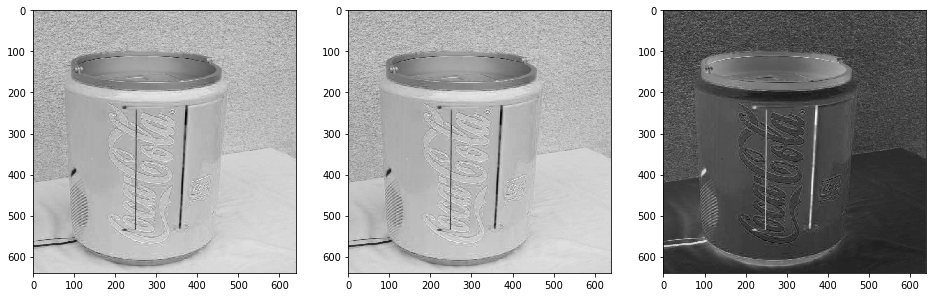

In [20]:
images = [colaImageMat[:,:,0], newY, (colaImageMat[:,:,0] - newY) ]

fig=plt.figure(figsize=(16, 16))

columns = 3
rows = 1
for i in range(1, 4):
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1], cmap = "gray")
plt.show()

# 1.5 Encoding

In [21]:
# ! pip install dahuffman

In [22]:
def encodemat(imgChannel):
    
    key, counts = np.unique(imgChannel, return_counts = True)
    dic = {key[i]: counts[i] for i in range(len(key)) }
    
    codec = HuffmanCodec.from_frequencies(dic)
    encoded = codec.encode(imgChannel.flatten())
    
    return encoded, codec, imgChannel.shape

In [23]:
def decodemat(encodedImgChannel, codec, shape):
    
    decoded = codec.decode(encodedImgChannel)
    decoded = np.array(decoded)
    
    return decoded.reshape(shape)

In [24]:
encoded, codec, shape = encodemat(y_dash)

In [26]:
decoded = decodemat(encoded, codec, shape)

In [27]:
False not in (decoded == y_dash)

True

# 1.6 Decompression